In [2]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function

# The main mapwork module
from enlib import enmap

import numpy as np
# Tools for working with enmaps, i/o, catalogs and statistics
from orphics import maps,io,stats,cosmology

from enlib import colorize, resample                                                                                                                           
colorize.mpl_setdefault("planck") 


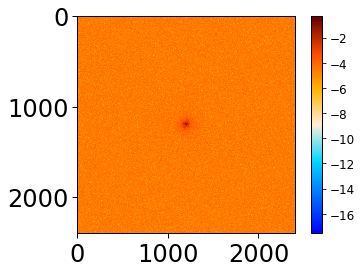

/home/msyriac/.local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


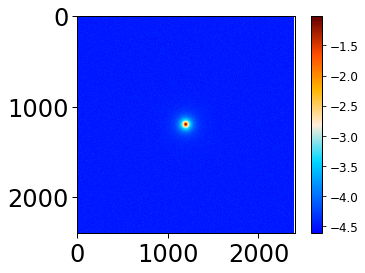

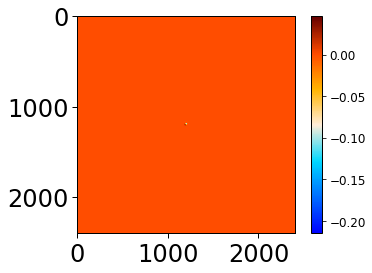

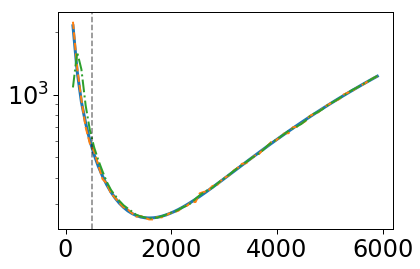

In [44]:
shape,wcs = maps.rect_geometry(width_deg=20.,height_deg=20.,px_res_arcmin=0.5)
modlmap = enmap.modlmap(shape,wcs)
modrmap = enmap.modrmap(shape,wcs)

kmask = maps.mask_kspace(shape,wcs,lmin=100)
    
def get_p2d(noisy=True):
    uk_arcmin = 20.
    lknee = 2000.
    alpha = -3.
    p2d = kmask*cosmology.white_noise_with_atm_func(modlmap,uk_arcmin,
                                                    lknee,alpha,dimensionless=False,TCMB=2.7255e6)
    if not(noisy): return p2d
    mg = maps.MapGen(shape,wcs,p2d.reshape((1,1,shape[0],shape[1]))*4.)
    splits = []
    for i in range(4):
        splits.append(mg.get_map())
    p2d,_ = maps.noise_from_splits(splits)    
    return p2d
    
p2d = get_p2d()
io.plot_img(np.fft.fftshift(np.log10(p2d)))#,lim=[-0.5,1.2])
dfact = 8
order = 1

dp2d = maps.downsample_power(shape,wcs,p2d,ndown=dfact,order=order,exp=None,fftshift=True)
io.plot_img(np.fft.fftshift(np.log10(dp2d*kmask)))
io.plot_img(np.fft.fftshift((dp2d*kmask-get_p2d(noisy=False)*kmask)))

bin_edges = np.arange(100,6000,80)
binner = stats.bin2D(modlmap,bin_edges)

cents,p1d = binner.bin(get_p2d(noisy=False)*kmask)
cents,n1d = binner.bin(p2d)
cents,d1d = binner.bin(dp2d)
pl = io.Plotter(yscale='log')
pl.add(cents,cents**2.*p1d,lw=3)
pl.add(cents,cents**2.*n1d,ls="--",lw=2)
pl.add(cents,cents**2.*d1d,ls="-.",lw=2)
pl.vline(x=500.)
pl.done()

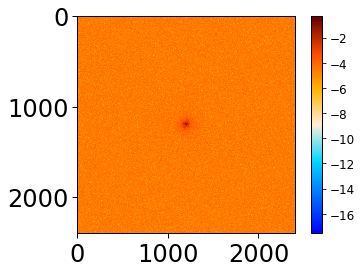

/home/msyriac/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/msyriac/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


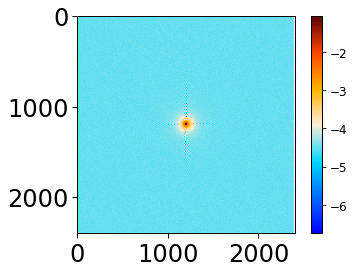

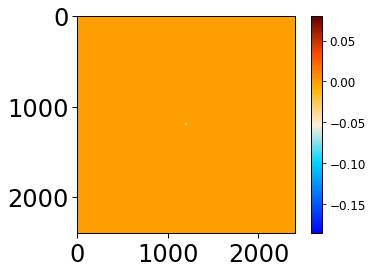

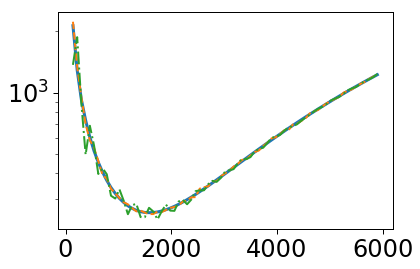

In [45]:
io.plot_img(np.fft.fftshift(np.log10(p2d)))
dp2d = maps.downsample_power(shape,wcs,p2d,ndown=dfact,order=order,exp=None,fftshift=True,fft=True)
io.plot_img(np.fft.fftshift(np.log10(dp2d)))
io.plot_img(np.fft.fftshift((dp2d-get_p2d(noisy=False))))

cents,p1d = binner.bin(get_p2d(noisy=False))
cents,n1d = binner.bin(p2d)
cents,d1d = binner.bin(dp2d)
pl = io.Plotter(yscale='log')
pl.add(cents,cents**2.*p1d,lw=3)
pl.add(cents,cents**2.*n1d,ls="--",lw=2)
pl.add(cents,cents**2.*d1d,ls="-.",lw=2)
pl.done()


In [46]:
pcov = np.zeros((3,3,shape[0],shape[1]))
for i in range(3):
    for j in range(i,3):
        pcov[i,j] = get_p2d(noisy=True)
        if i!=j: pcov[j,i] = pcov[i,j].copy()


In [48]:
pcov.shape
enmap.downgrade(pcov,4).shape

(3, 3, 600, 600)